# Import packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder


Using TensorFlow backend.


# Load the data

In [2]:
df=pd.read_csv('/Users/yingyuxuan/Desktop/covid19-global-forecasting-week-5/data/new_df.csv').drop(columns='Unnamed: 0')
df.head()

,Country_Region,Date,month,day,Population,Weight,Target,TargetValue
0,Afghanistan,2020-01-23,1,23,27657145,0.058359,ConfirmedCases,0.0
1,Afghanistan,2020-01-23,1,23,27657145,0.583587,Fatalities,0.0
2,Afghanistan,2020-01-24,1,24,27657145,0.058359,ConfirmedCases,0.0
3,Afghanistan,2020-01-24,1,24,27657145,0.583587,Fatalities,0.0
4,Afghanistan,2020-01-25,1,25,27657145,0.058359,ConfirmedCases,0.0


In [3]:
# obtian fatality cases data 
fatality=df[df.Target=='Fatalities'].drop(columns='Target')

In [4]:
#top 10 countries by confiremd cases 
top_10_countries=pd.DataFrame(fatality.groupby('Country_Region')['TargetValue'].sum()).sort_values(by='TargetValue',ascending=False).reset_index()
top_10_country_names=top_10_countries.Country_Region[:11]

# Data Standardization

In [5]:
# normalized the data 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(fatality.drop(columns=['TargetValue','Country_Region','Date']))

In [6]:
# create datefrane fir scaled data
scaled_df=pd.DataFrame(data=scaled,columns=fatality.drop(columns=['TargetValue','Country_Region','Date']).columns)

In [7]:
fa=fatality.copy()
fa[scaled_df.columns]=np.array(scaled_df)
fa['country']=list(fa.Country_Region)


In [8]:
fa=fa.set_index(['Country_Region','Date'])
fa.head()

month       day  Population  Weight  TargetValue  \
Country_Region Date                                                           
Afghanistan    2020-01-23    0.0  0.733333    0.019815  0.0616          0.0   
               2020-01-24    0.0  0.766667    0.019815  0.0616          0.0   
               2020-01-25    0.0  0.800000    0.019815  0.0616          0.0   
               2020-01-26    0.0  0.833333    0.019815  0.0616          0.0   
               2020-01-27    0.0  0.866667    0.019815  0.0616          0.0   

                               country  
Country_Region Date                     
Afghanistan    2020-01-23  Afghanistan  
               2020-01-24  Afghanistan  
               2020-01-25  Afghanistan  
               2020-01-26  Afghanistan  
               2020-01-27  Afghanistan

# Train Test Split

In [9]:
def train_test_split(data):
    size=int(len(data)*0.8)
    # for train data will be collected from each country's data which index is from 0-size (80%)
    x_train =data.drop(columns=['TargetValue']).iloc[0:size] 
    # for test data will be collected from each country's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['TargetValue']).iloc[size:]
    y_train=data['TargetValue'].iloc[0:size] 
    y_test=data['TargetValue'].iloc[size:] 
    return x_train, x_test,y_train,y_test

In [10]:
country=list(set(fa.country))
# loop each station and collect train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=fa[fa['country']==country[i]]
    x_train, x_test,y_train,y_test=train_test_split(data)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [11]:
# concat each train data from each station 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concat each test data from each station 
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

In [12]:
# double check the train data and test data and our target 
X_train.head(2)

month       day  Population    Weight country
Country_Region Date                                                     
Poland         2020-01-23    0.0  0.733333    0.027538  0.055366  Poland
               2020-01-24    0.0  0.766667    0.027538  0.055366  Poland

# Data pre-processing

In [34]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test


In [15]:
encoder = LabelEncoder()
#combine x train and y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
#combine x test and y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])
test_data.shape

(85922, 6)

In [16]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

# Model 


In [17]:
# design network for confirmed cases data 
model = Sequential()
model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=30, batch_size=50, verbose=0, shuffle=False)

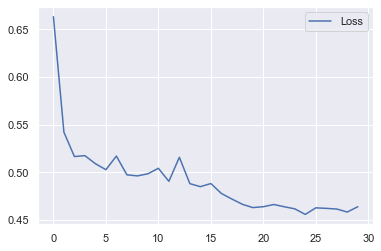

In [18]:
# plot history
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

# Make prediction

In [19]:
# make a prediction
y_test_pre=model.predict(x_test)

In [20]:
y_test_pre.shape,y_test.shape

((85921, 1), (85921,))

# Data Evaluation

In [21]:
# a little tricky thing is y_test prediction has one day lag so we need re-match the date 
len([i[0] for i in y_test_pre][1:]),len(y_test[:-1])  

(85920, 85920)

In [22]:
pa=pd.DataFrame()
pa['Date']=X_test.reset_index().Date.iloc[1:-1]
pa['Prediction']=[i[0] for i in y_test_pre][1:] 
pa['Actual Values']=y_test[:-1]
pa.head()

,Date,Prediction,Actual Values
1,2020-05-02,9.942091,13.0
2,2020-05-03,10.881908,14.0
3,2020-05-04,15.807694,20.0
4,2020-05-05,14.273212,18.0
5,2020-05-06,13.484845,17.0


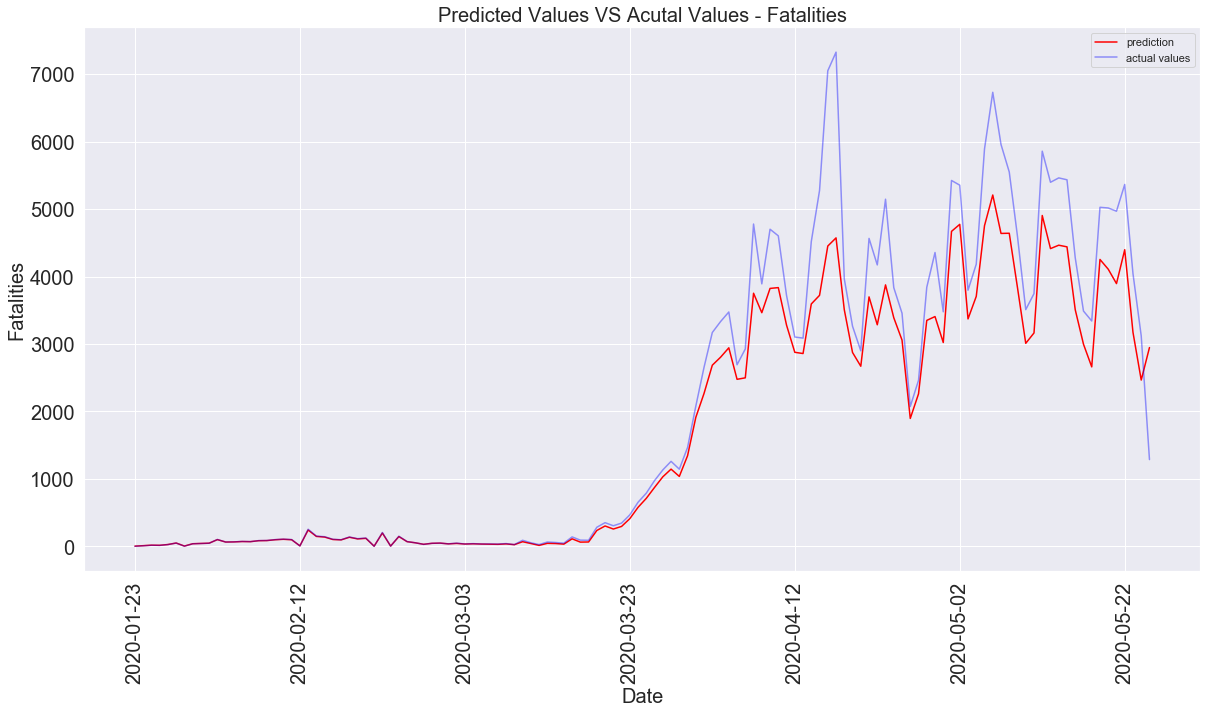

In [23]:
plt.figure(figsize=(20,10))
pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
pa.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
plt.xticks(rotation=90,size=20)
plt.yticks(size=20)

plt.ylabel('Fatalities',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Acutal Values - Fatalities',fontsize=20)
plt.legend()


In [32]:
from sklearn.metrics import mean_squared_error
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse

In [25]:
print(RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:]))

17.723653480839136


# LSTM for top 10 contries

In [26]:
def normalization_train_test_split(country):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(country.drop(columns=['TargetValue','Country_Region','Date']))
    # create datefrane fir scaled data
    scaled_df=pd.DataFrame(data=scaled,columns=country.drop(columns=['TargetValue','Country_Region','Date']).columns)
    scaled_df['TargetValue']=list(country.TargetValue)
    X_train, X_test,Y_train,Y_test=train_test_split(scaled_df)
    #combine x train and y train as train data 
    train_data=pd.DataFrame()
    train_data[X_train.columns]=X_train
    train_data['TargetValues']=Y_train
    #combine x test and y test as test data 
    test_data=pd.DataFrame()
    test_data[X_test.columns]=X_test
    test_data['TargetValues']=Y_test

    # using the function to obtian reshaped x_train,x_test,y_train,y_test
    x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)
    return x_train, x_test,y_train,y_test

US - RMSE: 7.656210587093691
United Kingdom - RMSE: 184.82514337675232
Italy - RMSE: 7.653354959740734
France - RMSE: 279.87921875845785
Spain - RMSE: 8.451508244650412
Brazil - RMSE: 51.672191033446765
Canada - RMSE: 7.535720682419885
Belgium - RMSE: 16.082070259821126
China - RMSE: 36.799935308519856
Germany - RMSE: 11.5322010834513
Mexico - RMSE: 50.32544350558548


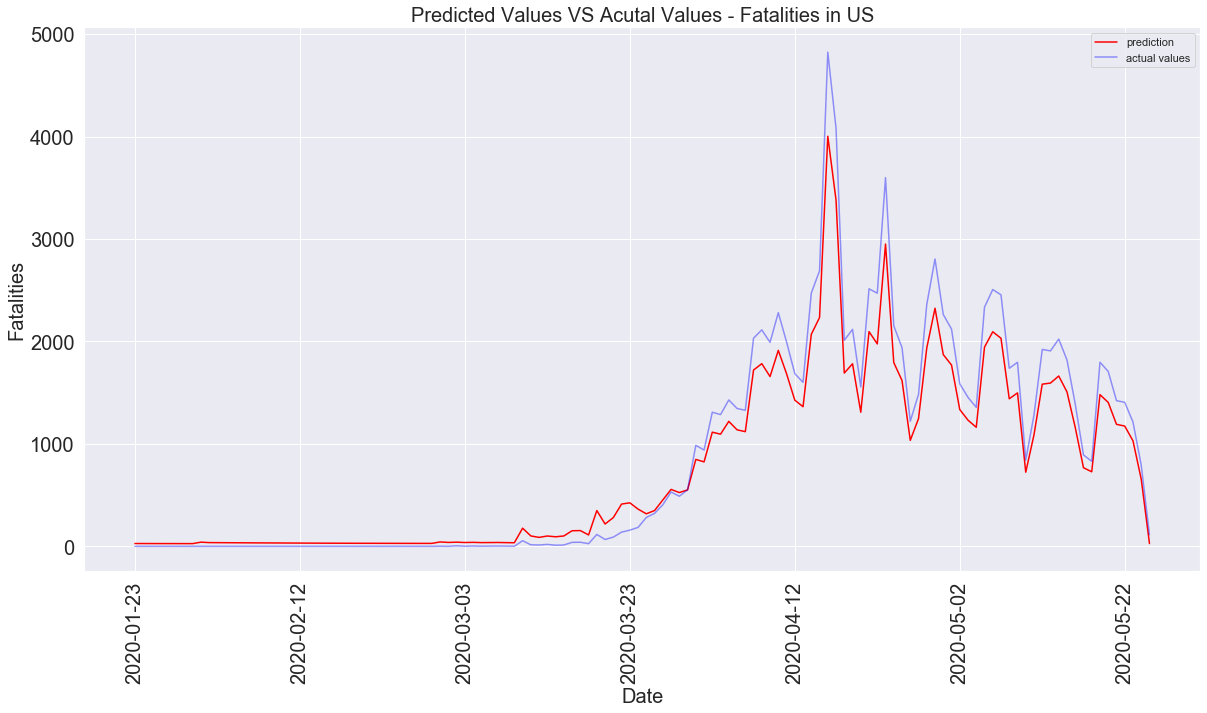

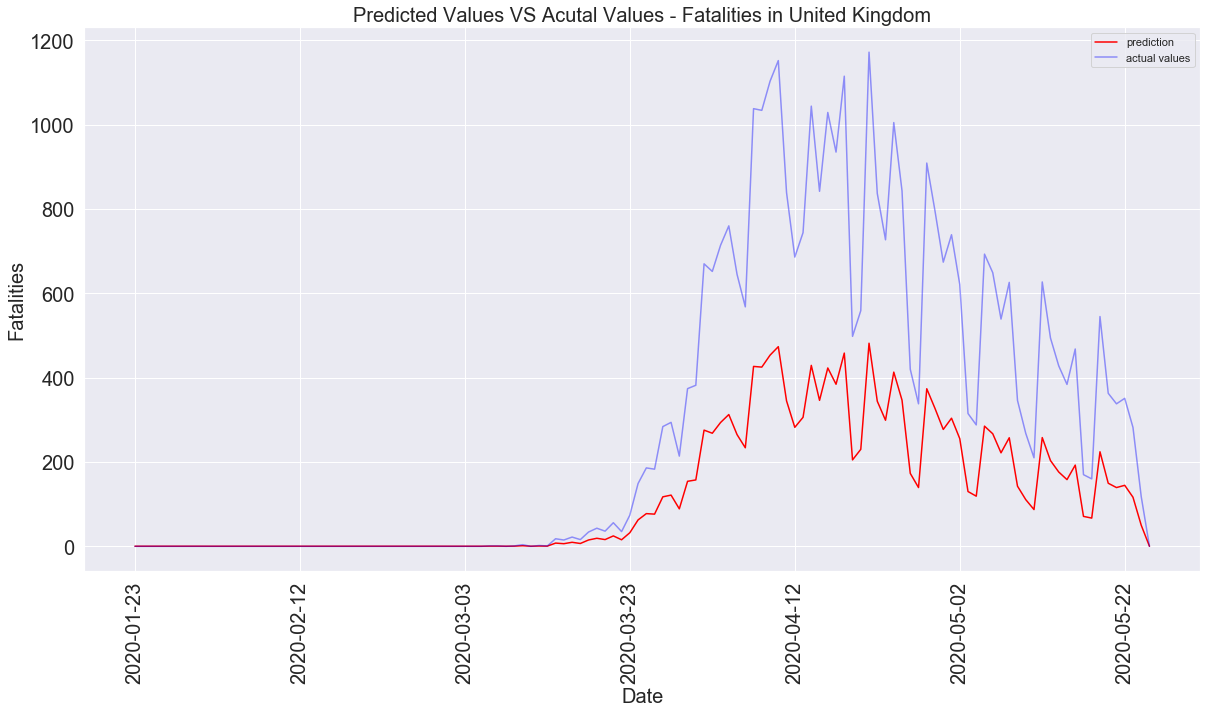

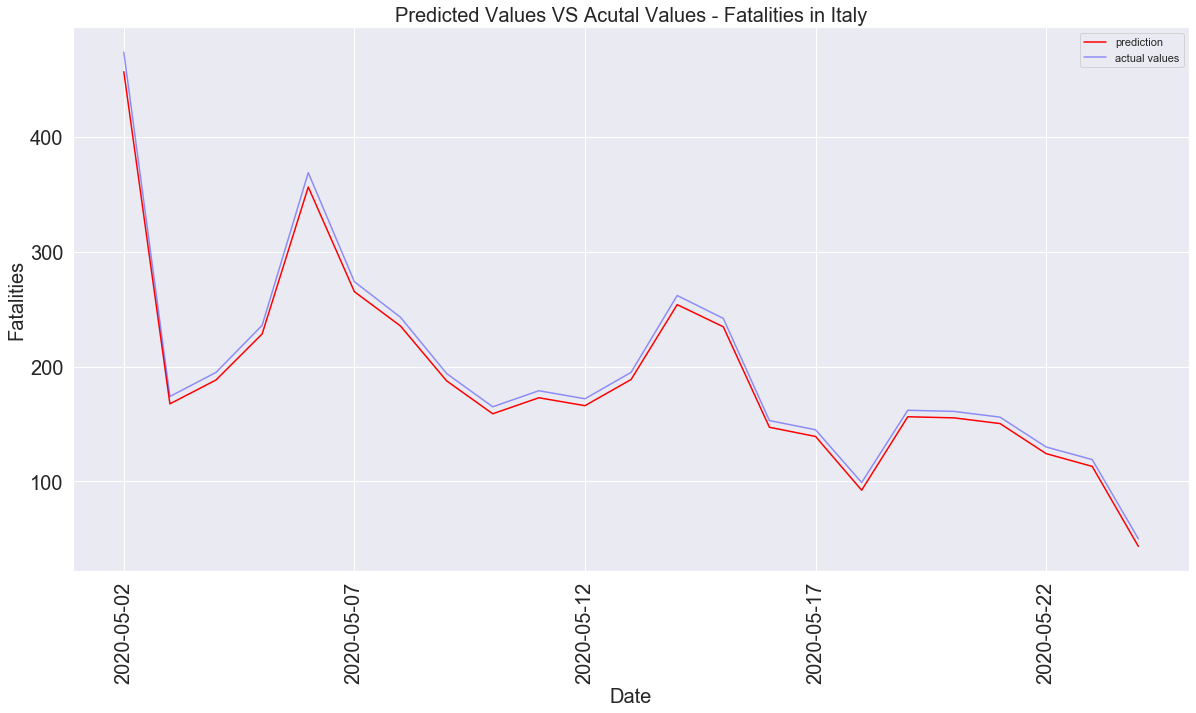

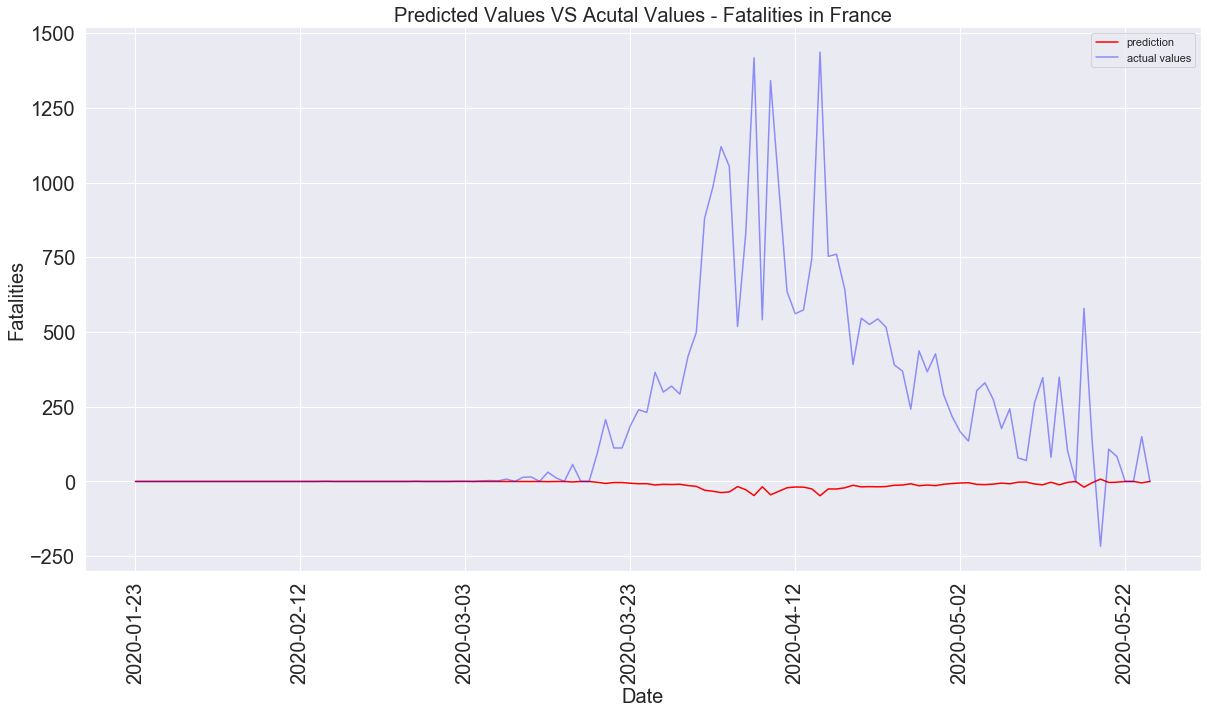

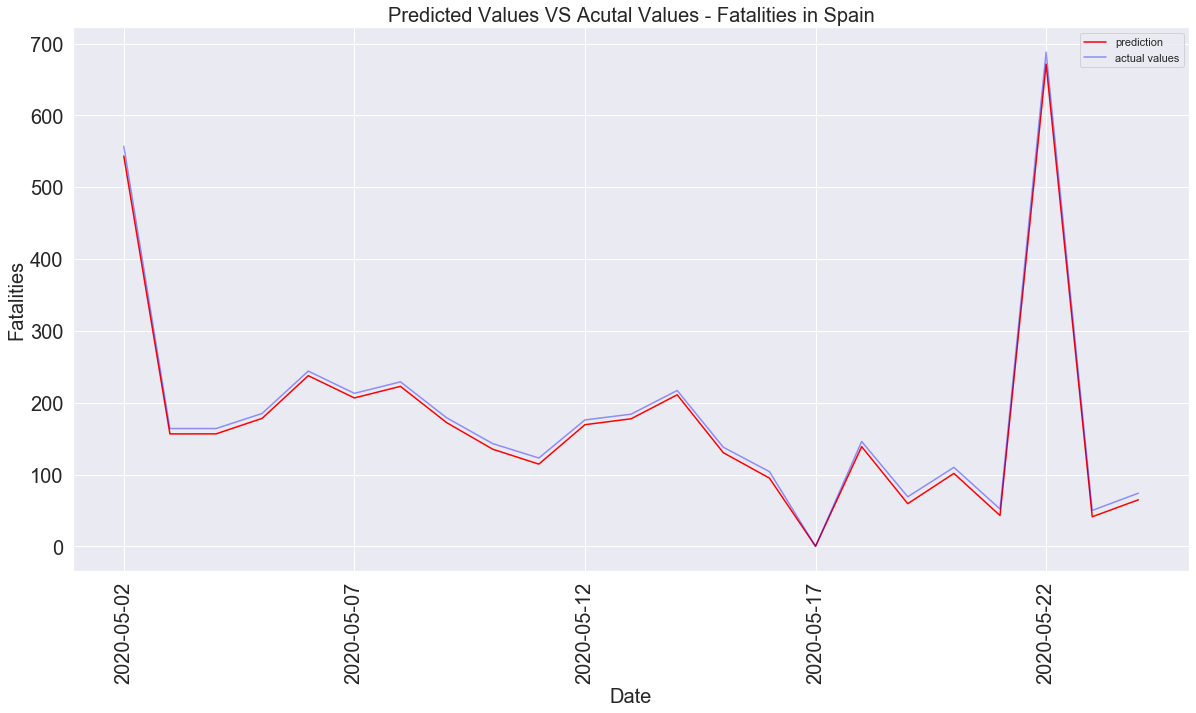

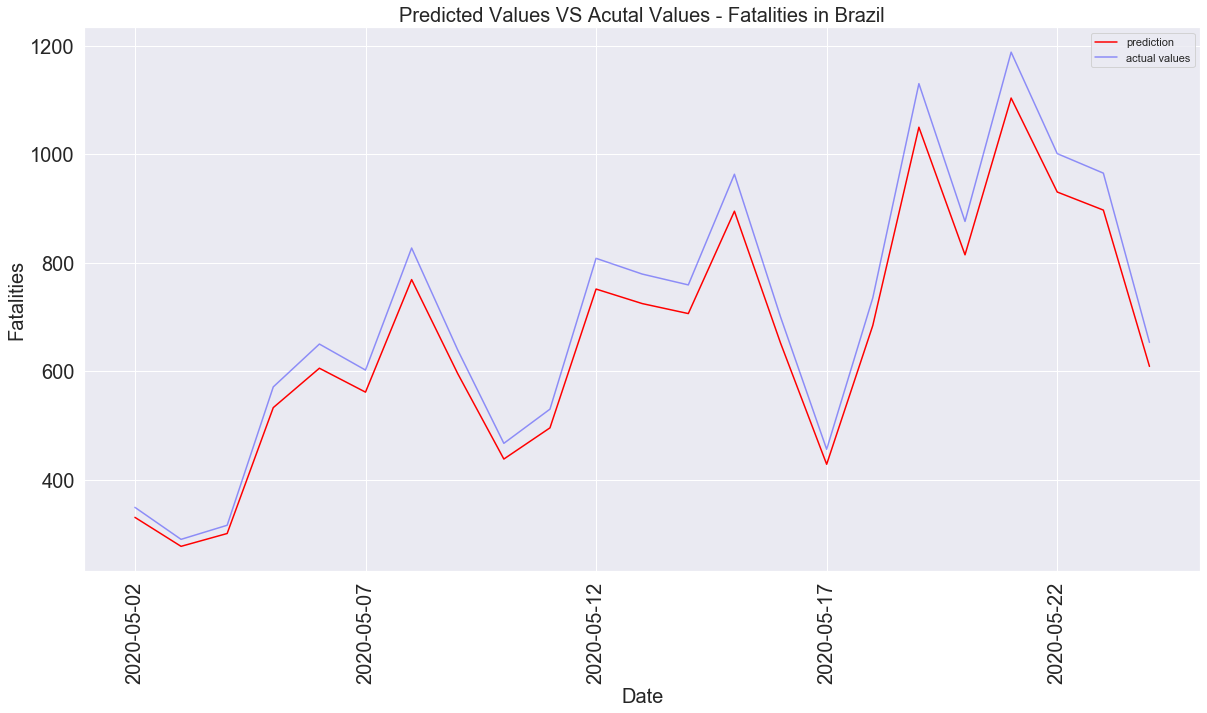

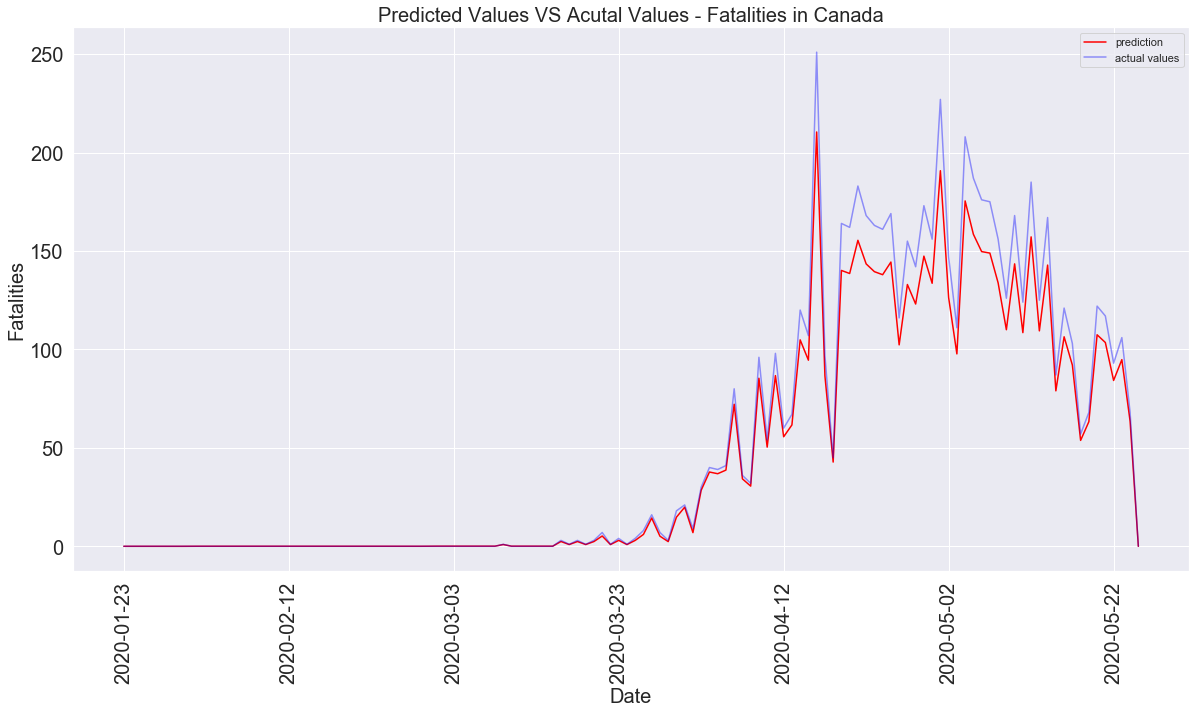

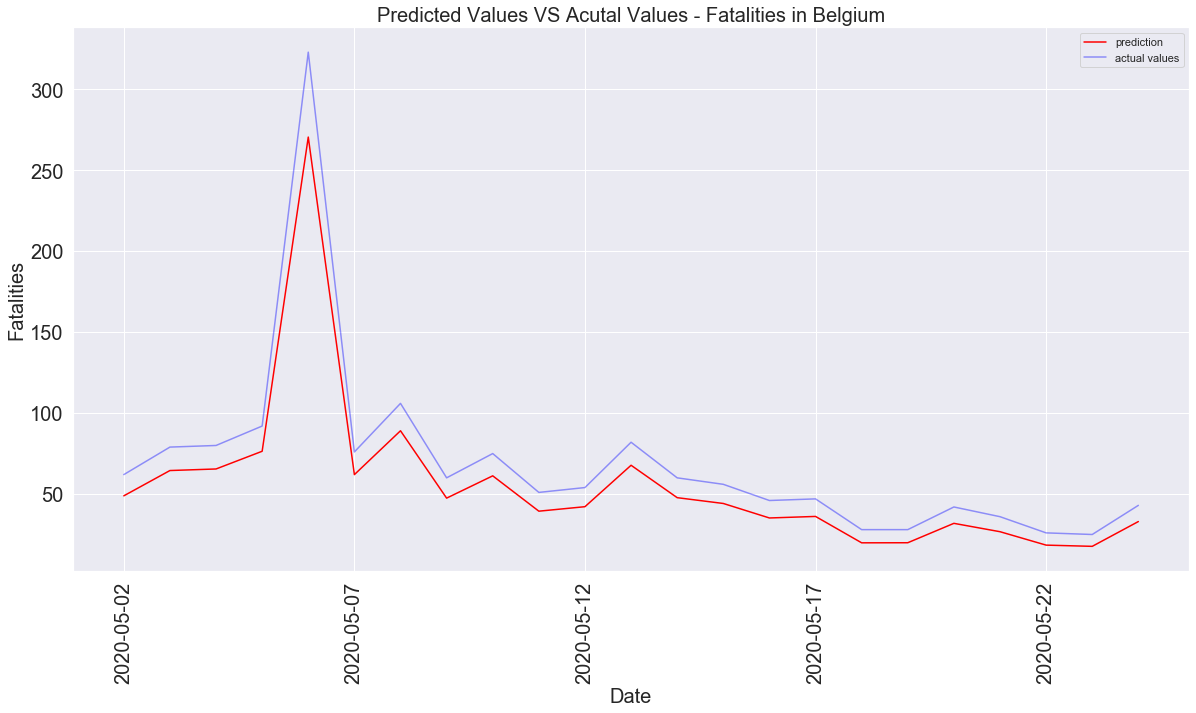

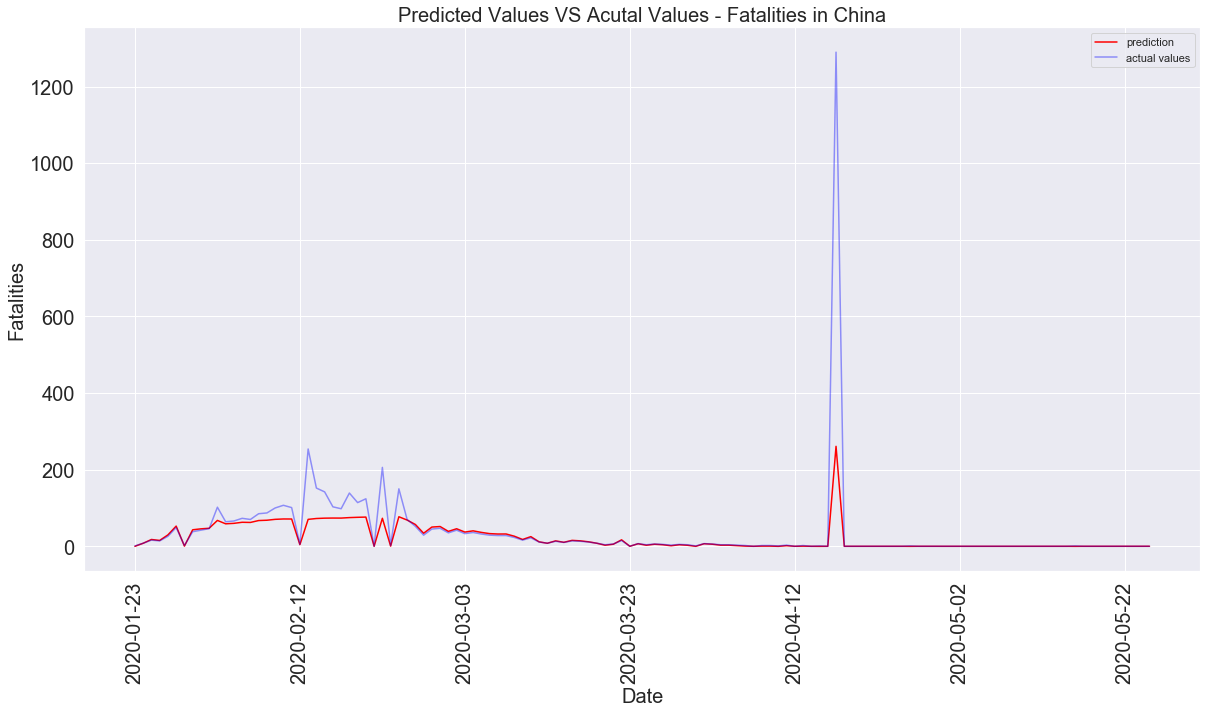

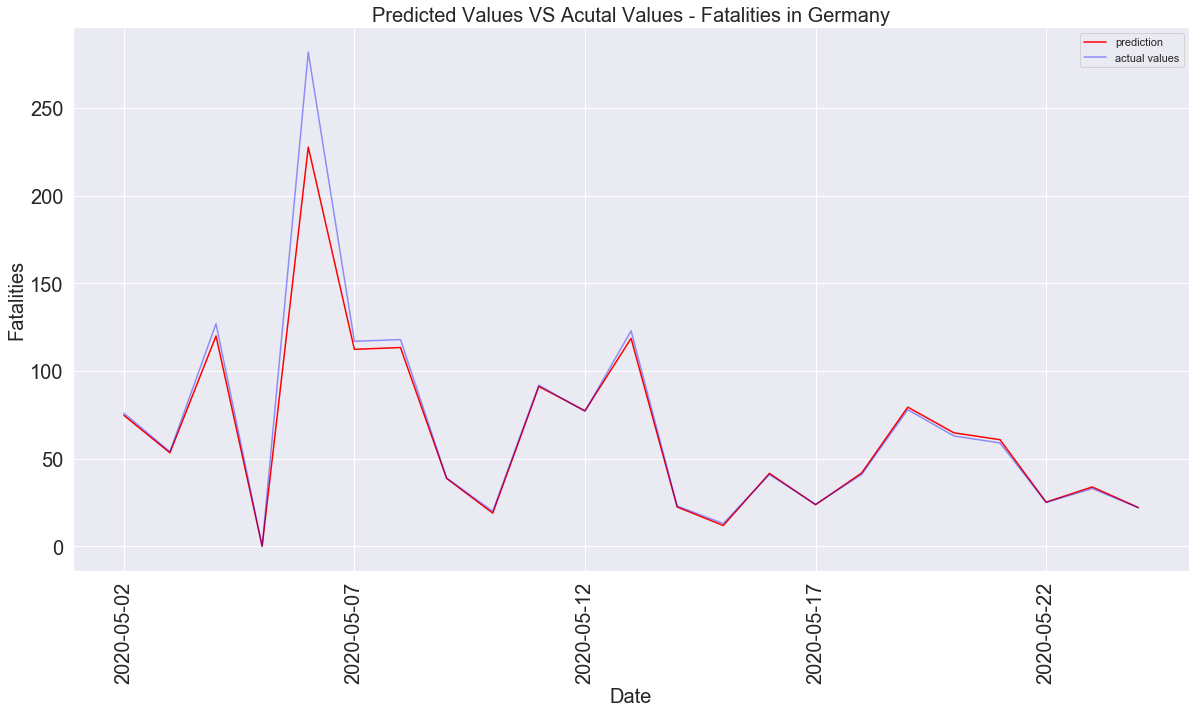

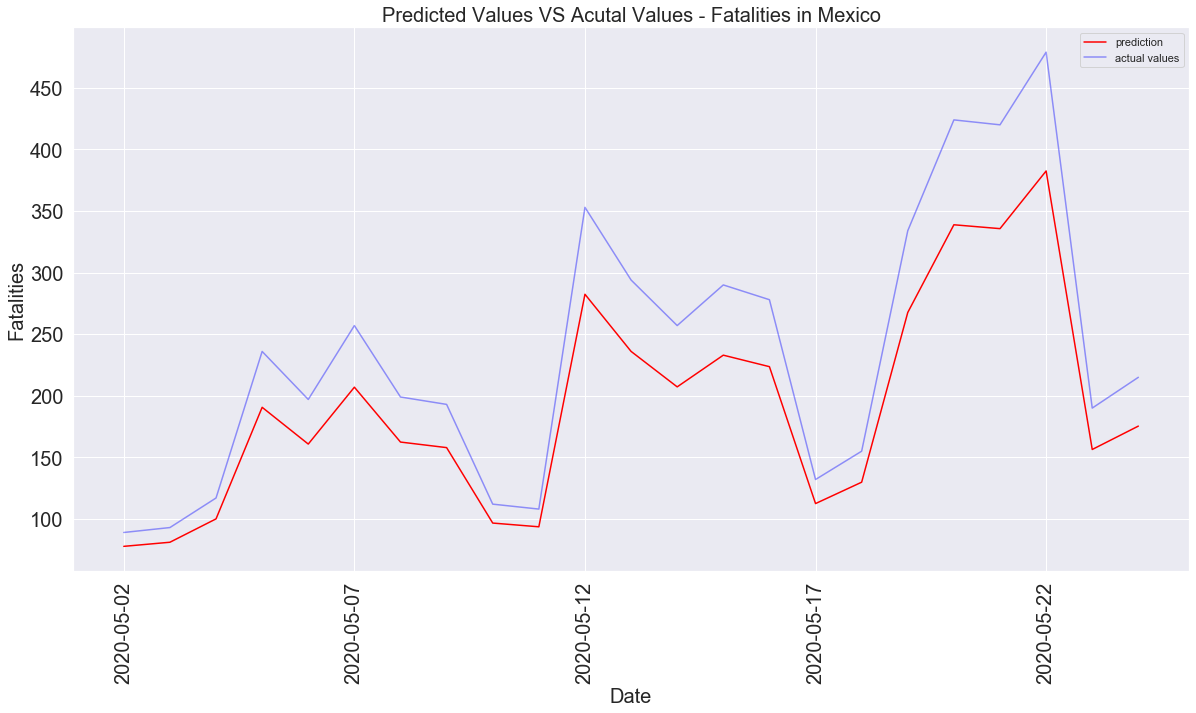

In [33]:
# loop through top 10 countries' data 
# 
for i in range(len(top_10_country_names)): 
     # obtian one country's data 
    country=fatality[fatality.Country_Region==top_10_country_names[i]]
    # train test split, nomalization and reshape the data
    x_train, x_test,y_train,y_test=normalization_train_test_split(country)
    # model 
    model = Sequential()
    model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(x_train, y_train, epochs=50, batch_size=30,  verbose=0, shuffle=False)
    # make a prediction
    y_test_pre=model.predict(x_test)
    #RMSE
    rmse=RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:])
    print('{} - RMSE: {}'.format(top_10_country_names[i],rmse))
    #create new dataframe for plot 
    pa=pd.DataFrame()
    pa['Date']=list(country.Date.iloc[int(len(country)*0.8):])[1:-1]
    pa['Prediction']=[i[0] for i in y_test_pre][1:] 
    pa['Actual Values']=list(y_test[:-1])

    plt.figure(figsize=(20,10))
    pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
    pa.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
    plt.xticks(rotation=90,size=20)
    plt.yticks(size=20)

    plt.ylabel('Fatalities',fontsize=20)
    plt.xlabel('Date',fontsize=20)
    plt.title('Predicted Values VS Acutal Values - Fatalities in {}'.format(top_10_country_names[i]),fontsize=20)
    plt.legend()